In [39]:
import numpy as np
from numpy import linalg as LA
import pyfftw
import matplotlib.pyplot as plt
import scipy.linalg
from matplotlib.colors import ListedColormap

In [13]:
###############################################################################
#POD Routines
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]  
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u

In [14]:
#%% Main program:
# Inputs
nx =  256   #spatial grid number
ny = 256    #spatial grid number
nc = 8      #number of control parameters (nu)
ns = 200    #number of snapshot per each Parameter a
Re_start = 100.0 #Lower range of Reynods number
Re_final = 800.0 #Upper range of Reynolds number
Re  = np.linspace(Re_start, Re_final, nc) #control Reynolds
nu = 1/Re   #control dissipation
lx = 2.0*np.pi
ly = 2.0*np.pi
dx = lx/nx
dy = ly/ny
dt = 1e-1
tm = 20.0
ReTest = 500
training = 'true'

In [15]:
#%% Data generation for training
x = np.linspace(0, lx, nx+1)
y = np.linspace(0, ly, ny+1)
t = np.linspace(0, tm, ns+1)

um = np.zeros(((nx)*(ny), ns+1, nc))
up = np.zeros(((nx)*(ny), ns+1, nc))
uo = np.zeros(((nx)*(ny), ns+1, nc))

for p in range(0,nc):
    for n in range(0,ns+1):
        file_input = "./snapshots/Re_"+str(int(Re[p]))+"/w/w_"+str(int(n))+ ".csv"
        w = np.genfromtxt(file_input, delimiter=',')
        
        w1 = w[1:nx+1,1:ny+1]
        
        um[:,n,p] = np.reshape(w1,(nx)*(ny)) #snapshots from unperturbed solution
        uo[:,n,p] = um[:,n,p] 

In [17]:
nr = 8 #number of POD modes
n_sensors = nr #number of sensors

In [18]:
u_vec = np.reshape(uo,((nx)*(ny),-1)) 
Phi_vec,L,RIC = POD(u_vec,nr) #basis construction

99.90311630909532


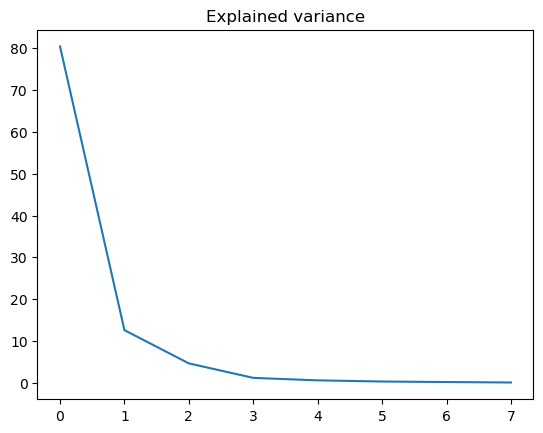

In [21]:
L_ = L/np.sum(L)*100
plt.plot(L_[:nr])
plt.title("Explained variance")
print(RIC)

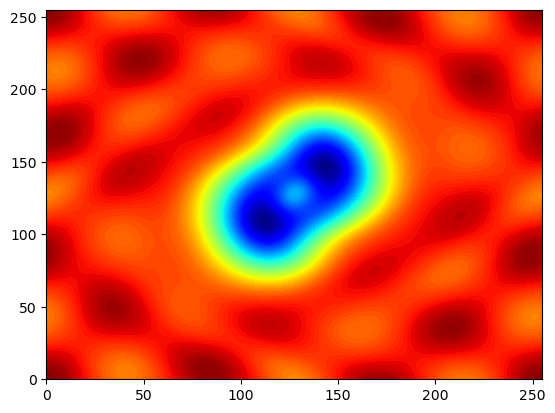

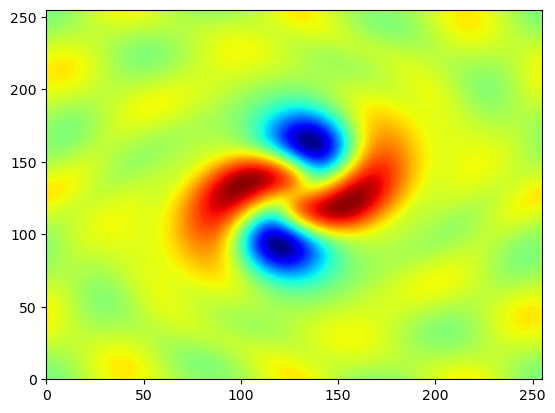

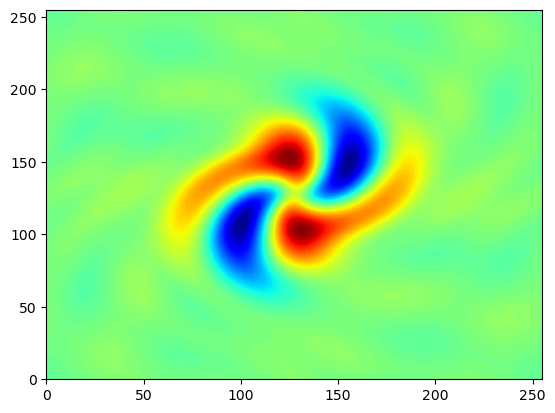

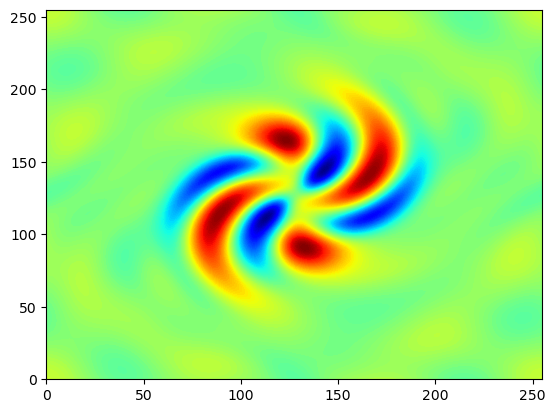

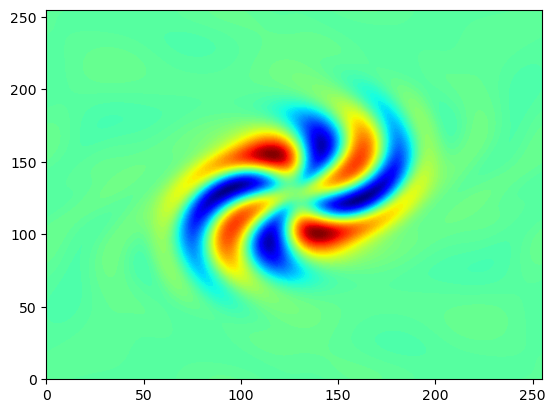

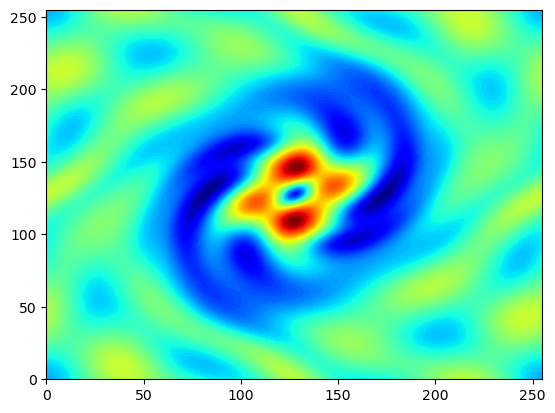

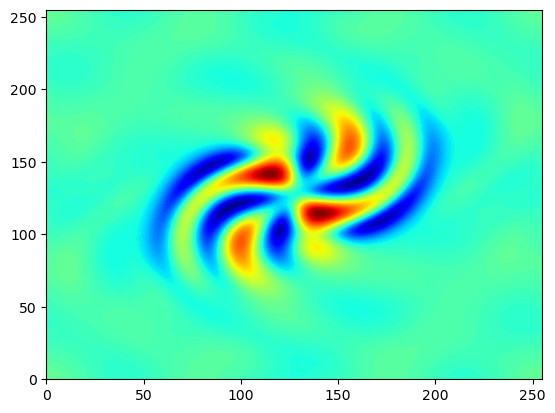

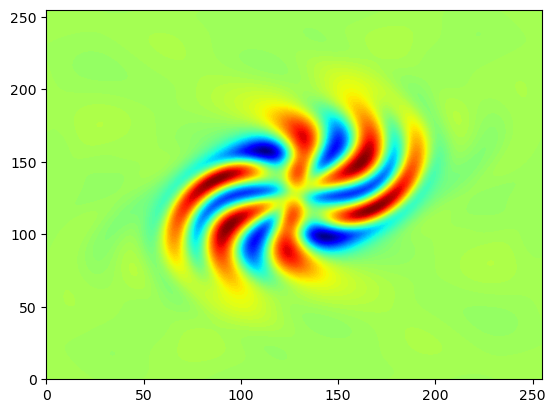

In [22]:
Phi=Phi_vec.reshape(nx,ny,nr)
for i in range(0,nr):
    plt.contourf(Phi[:,:,i],120, cmap = 'jet')
    plt.show()

In [24]:
# Sensor placement

def qr_pivots(Psi_r, num_eigen, num_sensors=None):
    if num_sensors is None:
        num_sensors = num_eigen
    
    M = Psi_r.T
    if num_sensors > num_eigen:
        M = Psi_r @  Psi_r.T

    Q, R, P = scipy.linalg.qr(M, pivoting=True)
    return P

def find_sensor_placement(Psi_r, num_eigen, num_sensors=None):
    P = qr_pivots(Psi_r, num_eigen, num_sensors)
    C = np.zeros((num_sensors,Psi_r.shape[0]))
    C[np.arange(num_sensors),P[:num_sensors]] = 1
    return C

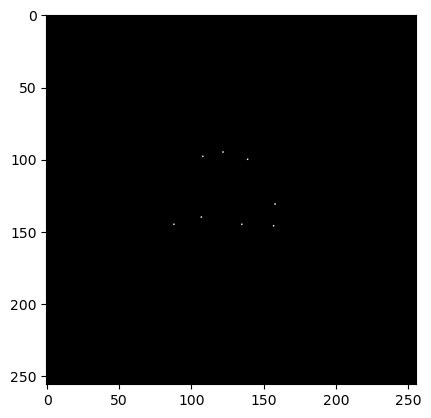

In [64]:
C = find_sensor_placement(Phi_vec, nr, n_sensors)
C_mat = C.sum(axis=0).reshape(nx,ny)
plt.imshow(C_mat, cmap = 'gray')
plt.show()

In [26]:
theta = C @ Phi_vec
theta_inv = LA.pinv(theta)

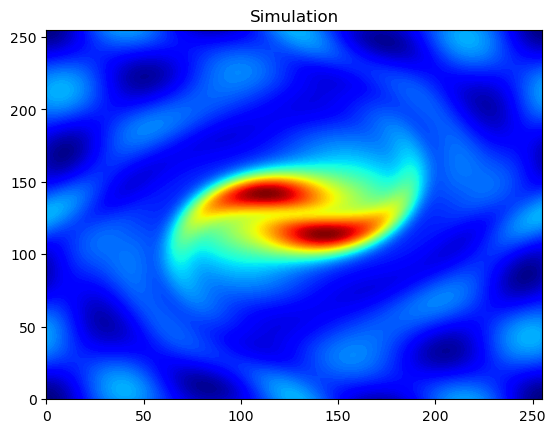

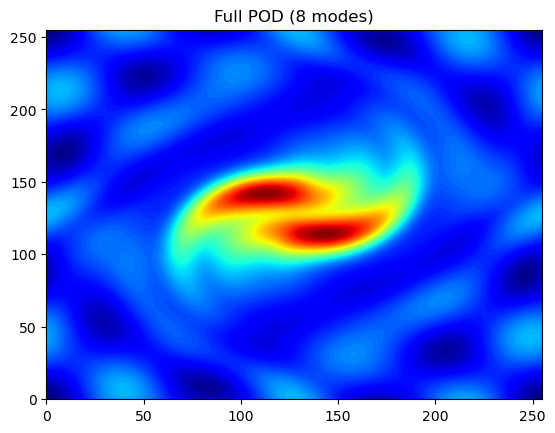

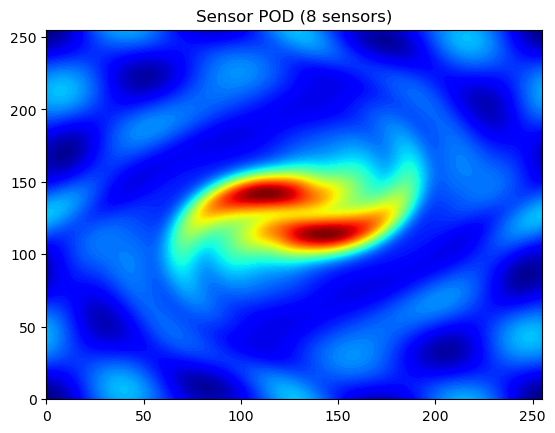

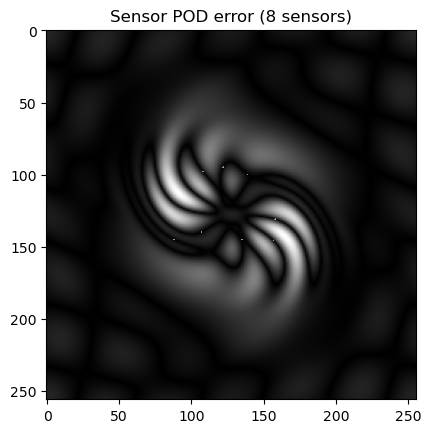

In [92]:
# Reconstruction using only sensors

index = np.random.choice(u_vec.shape[1])

y = C @ u_vec[:,index]
y_max = np.max(np.abs(y))
a = theta_inv @ y
u_vec_sens_rec = PODrec(a,Phi_vec)

# Reconstruction using full POD
u_vec_rec = PODrec(PODproj(u_vec[:,index], Phi_vec),Phi_vec)


plt.title("Simulation")
plt.contourf(u_vec[:,index].reshape(nx,ny),120, cmap = 'jet')
plt.show()

plt.title("Full POD (" + str(nr) + " modes)")
plt.contourf(u_vec_rec.reshape(nx,ny),120, cmap = 'jet')
plt.show()



plt.title("Sensor POD (" + str(n_sensors) + " sensors)")
plt.contourf(u_vec_sens_rec.reshape(nx,ny),120, cmap = 'jet')
plt.show()


plt.title("Sensor POD error (" + str(n_sensors) + " sensors)")
plt.imshow(np.abs(u_vec[:,index] - u_vec_sens_rec).reshape(nx,ny),cmap = 'gray')
plt.imshow(C_mat, cmap =ListedColormap([(0,0,0,0), (0,1,0,1)]), vmin=0, vmax=1)

plt.show()


In [87]:
## Total error over all samples:
N = u_vec.shape[1]

A = theta_inv @ C @ u_vec
u_vec_sens_rec = PODrec(A.T,Phi_vec)

u_vec_pod_rec = PODrec(PODproj(u_vec, Phi_vec),Phi_vec)

sum_error_pod = np.sum(np.linalg.norm(u_vec_pod_rec - u_vec, axis=0)**2)
sum_error_sens = np.sum(np.linalg.norm(u_vec_sens_rec - u_vec, axis=0)**2)
sum_error_pod_sens = np.sum(np.linalg.norm(u_vec_sens_rec - u_vec_pod_rec, axis=0)**2)

total_sum_of_squares = np.sum(np.linalg.norm(u_vec -np.mean(u_vec, axis=0), axis=0)**2)
total_sum_of_sqares_pod = np.sum(np.linalg.norm(u_vec_pod_rec -np.mean(u_vec_pod_rec, axis=0), axis=0)**2)

print("POD error: " + str(sum_error_pod/N) + ", R2: " + str(1 - sum_error_pod/total_sum_of_squares))
print("Sensor POD error: " + str(sum_error_sens/N)+ ", R2: " + str(1 -sum_error_sens/total_sum_of_squares))
print("POD - Sensor POD error: " + str(sum_error_pod_sens/N)+ ", R2: " + str(1 - sum_error_pod_sens/total_sum_of_sqares_pod))


POD error: 1.3322576321399824, R2: 0.9988961439474113
Sensor POD error: 3.4966428178588784, R2: 0.997102819871233
POD - Sensor POD error: 2.164385185718896, R2: 0.9982047179825175


Maximum error in a single pixel: 0.016914676627017514


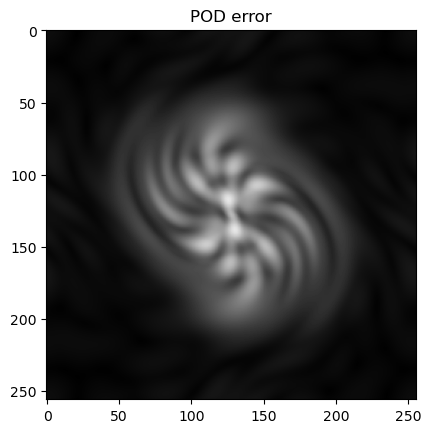

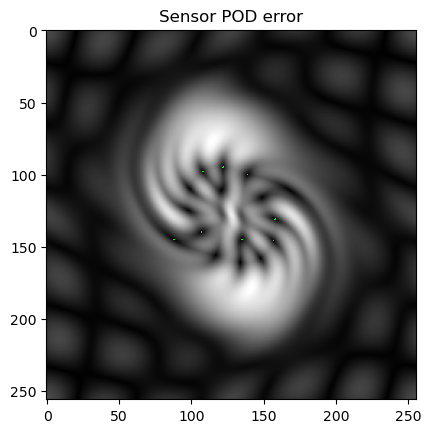

In [60]:
# Where in the image is the error:

error_pod = np.mean(np.abs(u_vec_pod_rec - u_vec), axis=1)
error_sensor = np.mean(np.abs(u_vec_sens_rec - u_vec), axis=1)

max = np.max([np.max(error_pod), np.max(error_sensor)])
print("Maximum error in a single pixel: " + str(max))

plt.imshow(error_pod.reshape(nx,ny),vmin=0, vmax=max, cmap = 'gray')
plt.title("POD error")
plt.show()


plt.imshow(error_sensor.reshape(nx,ny),vmin=0, vmax=max , cmap = 'gray')
plt.imshow(C_mat, cmap =ListedColormap([(0,0,0,0), (0,1,0,1)]), vmin=0, vmax=1)
plt.title("Sensor POD error")
plt.show()